# Pose Estimation Models

## Imports

In [1]:
import pandas as pd
import cv2 as cv
import numpy as np
import tensorflow as tf
import keras_tuner
import keras.backend as K
import math as m

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

np.set_printoptions(suppress = True)

---

## Variables

In [2]:
data_path_prefix = "D:/Uni Stuff/IP/Data/"
image_path_prefix = data_path_prefix + "Blimp Images/Raw/image_"

blimp_vertices = np.array([[1, 1, 1], [1, 1, -1], [1, -1, 1], [1, -1, -1], [-1, 1, 1], [-1, 1, -1], [-1, -1, -1], [-1, -1, 1]])

test_split = 0.25

desired_image_size = 16

X_columns = ["cent_x", "cent_y", "width", "height"]
colours = {0:"R", 1:"G", 2:"B"}

# Create list of column names like '0 0 R', '0 0 G', '0 0 B', '0 1 R' etc
for i in range(desired_image_size):
    for j in range(desired_image_size):
        for k in range(3):
            X_columns.append(str(i) + " " + str(j) + " " + colours[k])

---

## Data Pre-processing

### CSVs

Load the bounding box and pose csv files and add to dataframes

In [ ]:
bbox_data = pd.read_csv(data_path_prefix + "bbox data.csv")

pose_data = pd.read_csv(data_path_prefix + "blimp poses.csv")
y_variables = list(pose_data.columns)

### Images

Load the images from file, crop these by the bounding box and then resize to the desired square image size with padding to preserve aspect ratio. Image data is flattened and added to dataframe.

In [ ]:
# Crop the image to the bounding box coordinates
def cutout_image(image, bbox):
    width = image.shape[1]
    height = image.shape[0]

    center_x = bbox['cent_x'] * width
    center_y = bbox['cent_y'] * height

    bbox_width = bbox['width'] * width
    bbox_height = bbox['height'] * height

    min_x = np.clip(int(center_x - (bbox_width / 2)), 0, width)
    max_x = np.clip(int(center_x + (bbox_width / 2)), 0, width) 

    min_y = np.clip(int(center_y - (bbox_height / 2)), 0, height)
    max_y = np.clip(int(center_y + (bbox_height / 2)), 0, height)

    return image[min_y:max_y, min_x:max_x]

# Resize the image to the desired_image_size square and pad with black if necessary
def resize_and_pad_image(image):
    old_size = image.shape[:2]

    size_ratio = float(desired_image_size) / max(old_size)

    new_size = tuple([int(x * size_ratio) for x in old_size])

    resized_image = cv.resize(image, (new_size[1], new_size[0]), interpolation=cv.INTER_AREA)

    delta_w = desired_image_size - new_size[1]
    delta_h = desired_image_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    return cv.copyMakeBorder(resized_image, top, bottom, left, right, cv.BORDER_CONSTANT, value=[0, 0, 0])

for i in range(len(pose_data)):
    img = cv.imread(image_path_prefix + str(i) + ".png")
    cropped = cutout_image(img, bbox_data.iloc[i])
    padded = resize_and_pad_image(cropped)

    cv.imwrite(data_path_prefix + "Processed Images/image_" + str(i) + ".png", padded)

In [ ]:
load_path = data_path_prefix + "Processed Images/image_"

save_path = data_path_prefix + "Pose Estimation Data/"
train_save_path = save_path + "train/"
test_save_path = save_path + "test/"

train_image_save_path = train_save_path + "images/image_"
test_image_save_path = test_save_path + "images/image_"

train_nums, test_nums, = train_test_split(np.arange(15000), test_size=0.15)

bbox_train = pd.DataFrame(columns=["image", "cent_x", "cent_y", "width", "height"])
bbox_test = pd.DataFrame(columns=["image", "cent_x", "cent_y", "width", "height"])

pose_train = pd.DataFrame(columns=["image", "pos_x", "pos_y", "pos_z", "rot_x", "rot_y", "rot_z"])
pose_test = pd.DataFrame(columns=["image", "pos_x", "pos_y", "pos_z", "rot_x", "rot_y", "rot_z"])

for num in train_nums:
    image = cv.imread(load_path + str(num) + ".png")
    cv.imwrite(train_image_save_path + str(num) + ".png", image)

    bbox_train.loc[len(bbox_train)] = np.append([num], bbox_data.iloc[num])

    pose_train.loc[len(pose_train)] = np.append([num], pose_data.iloc[num])

bbox_train.to_csv(train_save_path + "bbox data.csv", index=False)
pose_train.to_csv(train_save_path + "pose data.csv", index=False)

print("Training done")

for num in test_nums:
    image = cv.imread(load_path + str(num) + ".png")
    cv.imwrite(test_image_save_path + str(num) + ".png", image)

    bbox_test.loc[len(bbox_test)] = np.append([num], bbox_data.iloc[num])

    pose_test.loc[len(pose_test)] = np.append([num], pose_data.iloc[num])

bbox_test.to_csv(test_save_path + "bbox data.csv", index=False)
pose_test.to_csv(test_save_path + "pose data.csv", index=False)

print("Testing done")

In [ ]:
bbox = pd.read_csv(train_save_path + "bbox data.csv")
print(bbox)

### Cleanup

Remove unecessary variables from RAM

In [ ]:
del bbox_data
del pose_data

---

## ADD Metric

Create functions to calculate ADD

In [3]:
# Get the rotation matrix of an XYZ rotation with the euler angles vector
def get_rotation_matrix(rot_vec):
    x_matrix = np.matrix([[ 1, 0, 0],
                          [ 0, m.cos(m.radians(rot_vec[0])),-m.sin(m.radians(rot_vec[0]))],                         
                          [ 0, m.sin(m.radians(rot_vec[0])), m.cos(m.radians(rot_vec[0]))]])
    
    y_matrix = np.matrix([[ m.cos(m.radians(rot_vec[1])), 0, m.sin(m.radians(rot_vec[1]))],
                          [ 0, 1, 0],
                          [-m.sin(m.radians(rot_vec[1])), 0, m.cos(m.radians(rot_vec[1]))]])
    
    z_matrix = np.matrix([[ m.cos(m.radians(rot_vec[2])), -m.sin(m.radians(rot_vec[2])), 0 ],
                          [ m.sin(m.radians(rot_vec[2])),  m.cos(m.radians(rot_vec[2])), 0 ],
                          [ 0, 0, 1 ]])
    
    return z_matrix * y_matrix * x_matrix

# Get the average distance between true and predicted model points
def get_ADD(true_trans, true_rot_vec, pred_trans, pred_rot_vec):
    true_rot = get_rotation_matrix(true_rot_vec).T
    pred_rot = get_rotation_matrix(pred_rot_vec).T

    total_distance = 0

    for vertex_pos in blimp_vertices:
        true_pos = np.matmul(true_rot, vertex_pos) - true_trans
        pred_pos = np.matmul(pred_rot, vertex_pos) - pred_trans

        distance = np.linalg.norm(true_pos - pred_pos)
        total_distance += distance

    return total_distance / len(blimp_vertices)

In [4]:
def ADD_metric(y_true, y_pred):
    true_trans = y_true[:3]
    true_rot_vec = y_true[3:]

    pred_trans = y_pred[:3]
    pred_rot_vec = y_pred[3:]

    return get_ADD(true_trans, true_rot_vec, pred_trans, pred_rot_vec)

---

In [5]:
train_images_path = data_path_prefix + "Pose Estimation Data/train/images/image_"

bbox_train = pd.read_csv(data_path_prefix + "Pose Estimation Data/train/bbox data.csv")

X_train = pd.DataFrame(columns=X_columns)

for i in range(len(bbox_train)):
    row = bbox_train.loc[i]
    num = int(row["image"])
    data = np.array([row[1], row[2], row[3], row[4]])

    image = cv.imread(train_images_path + str(num) + ".png")

    X_train.loc[len(X_train)] = np.append(data, image.flatten())

y_train = pd.read_csv(data_path_prefix + "Pose Estimation Data/train/pose data.csv")
y_train = y_train.drop(y_train.columns[0], axis=1)

In [5]:
test_images_path = data_path_prefix + "Pose Estimation Data/test/images/image_"

bbox_test = pd.read_csv(data_path_prefix + "Pose Estimation Data/test/bbox data.csv")

X_test = pd.DataFrame(columns=X_columns)

for i in range(len(bbox_test)):
    row = bbox_test.loc[i]
    num = int(row["image"])
    data = np.array([row[1], row[2], row[3], row[4]])

    image = cv.imread(test_images_path + str(num) + ".png")

    X_test.loc[len(X_test)] = np.append(data, image.flatten())

y_test = pd.read_csv(data_path_prefix + "Pose Estimation Data/test/pose data.csv")
y_test = y_test.drop(y_test.columns[0], axis=1)

## Training

Create normalizer function based on input data

In [7]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [8]:
tf.compat.v1.enable_eager_execution()

Create the DNN model and print details

In [28]:
def build_and_compile_model(hp):
  layers = [normalizer]

  starting_nodes_per_layer = hp.Int("staring_nodes_per_layer", 8, 128, step=8, sampling="log")
  
  for i in range(hp.Int("blocks", 1, 5)):
    nodes = starting_nodes_per_layer * (1 if (i == 0) else (i * 2))

    for _ in range(hp.Int("layers_per_block", 1, 5)): 
      layers.append(tf.keras.layers.Dense(nodes, activation='relu'))

  layers.append(tf.keras.layers.Dense(6))

  model = tf.keras.Sequential(layers)
  model.compile(loss = 'mean_squared_error', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(0.001))

  return model

tuner = keras_tuner.BayesianOptimization(
    build_and_compile_model,
    objective="val_loss",
    directory="logs/",
    max_trials=150
)

tensorboard_callback = tf.keras.callbacks.TensorBoard("mse_logs/")
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5)

tuner.search(
    X_train,
    y_train,
    validation_split=0.215,
    epochs=100,
    callbacks=[tensorboard_callback, early_stop_callback],
)

Trial 150 Complete [00h 07m 47s]
val_loss: 2.7604756355285645

Best val_loss So Far: 1.7224748134613037
Total elapsed time: 08h 25m 00s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [29]:
best_model = tuner.get_best_models()[0]

In [30]:
best_model.save("D:/Uni Stuff/IP/Coding/Repository/Blimp-Vision-System/Keras models/Best Squared Model")

INFO:tensorflow:Assets written to: D:/Uni Stuff/IP/Coding/Repository/Blimp-Vision-System/Keras models/Best Squared Model\assets


INFO:tensorflow:Assets written to: D:/Uni Stuff/IP/Coding/Repository/Blimp-Vision-System/Keras models/Best Squared Model\assets


---

## Evaluate

Plot the loss and epoch graph

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(best_model)

Evaluate performance out-of-sample on the testing data set

In [12]:
best_absolute_model = tf.keras.models.load_model("D:/Uni Stuff/IP/Coding/Repository/Blimp-Vision-System/Keras models/Best Absolute Model")

best_absolute_model.evaluate(X_test, y_test)

71/71 [==============================] - 0s 1ms/step - loss: 0.6317 - accuracy: 1.0000 - mean_absolute_error: 0.6317


[0.6317267417907715, 1.0, 0.6317267417907715]

Print the true and predicted poses

In [13]:
predictions = pd.DataFrame(best_absolute_model.predict(X_test), columns=["pos_x", "pos_y", "pos_z", "rot_x", "rot_y", "rot_z"])

add = []

for i in range(len(y_test)):
    add.append(ADD_metric(y_test.loc[i].to_numpy(), predictions.loc[0].to_numpy()))

71/71 [==============================] - 0s 872us/step


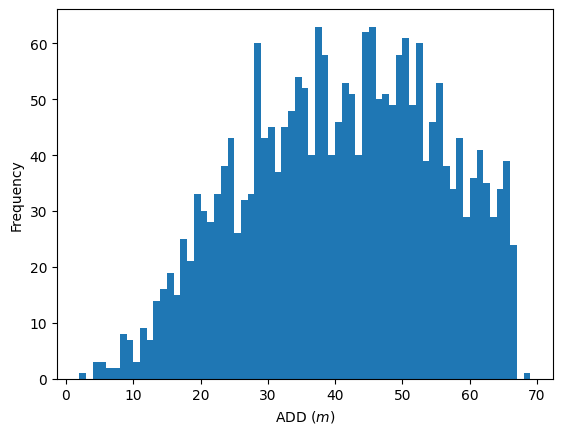

In [14]:
new_add = np.array(add) / 1

bin_width = 1
min_bin = int(np.min(new_add) - (np.min(new_add) % bin_width))
max_bin = int(np.max(new_add) + bin_width - (np.max(new_add) % bin_width))

plt.hist(new_add, bins=np.arange(min_bin, max_bin + bin_width, bin_width))

#xlim = [0, 1]

plt.xlabel("ADD ($m$)")
plt.ylabel("Frequency")
#plt.xlim(xlim)
plt.show()

In [16]:
best_absolute_percentage_model = tf.keras.models.load_model("D:/Uni Stuff/IP/Coding/Repository/Blimp-Vision-System/Keras models/Best Absolute Percentage Model")

best_absolute_percentage_model.evaluate(X_test, y_test)

71/71 [==============================] - 0s 857us/step - loss: 94.5539 - accuracy: 1.0000


[94.55387115478516, 1.0]

71/71 [==============================] - 0s 743us/step


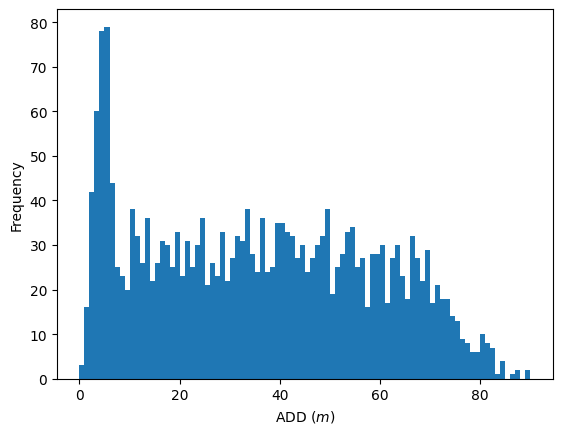

In [18]:
predictions = pd.DataFrame(best_absolute_percentage_model.predict(X_test), columns=["pos_x", "pos_y", "pos_z", "rot_x", "rot_y", "rot_z"])

add = []

for i in range(len(y_test)):
    add.append(ADD_metric(y_test.loc[i].to_numpy(), predictions.loc[0].to_numpy()))

bin_width = 1
min_bin = int(np.min(add) - (np.min(add) % bin_width))
max_bin = int(np.max(add) + bin_width - (np.max(add) % bin_width))

plt.hist(add, bins=np.arange(min_bin, max_bin + bin_width, bin_width))

#xlim = [0, 1]

plt.xlabel("ADD ($m$)")
plt.ylabel("Frequency")
#plt.xlim(xlim)
plt.show()

In [24]:
best_squared_log_model = tf.keras.models.load_model("D:/Uni Stuff/IP/Coding/Repository/Blimp-Vision-System/Keras models/Best Squared Logarithmic Model")

best_squared_log_model.evaluate(X_test, y_test)

71/71 [==============================] - 0s 1ms/step - loss: 0.0088 - accuracy: 1.0000


[0.008787216618657112, 1.0]

71/71 [==============================] - 0s 1ms/step


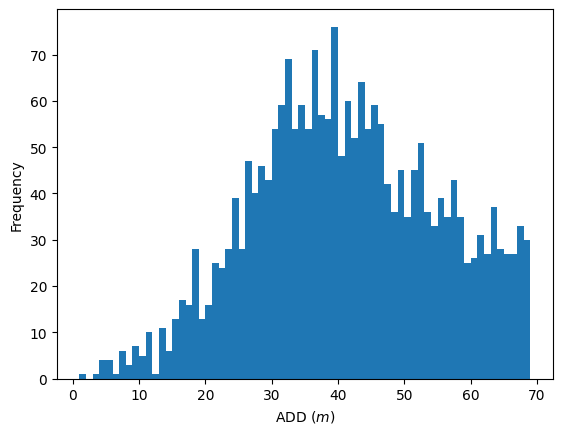

In [25]:
predictions = pd.DataFrame(best_squared_log_model.predict(X_test), columns=["pos_x", "pos_y", "pos_z", "rot_x", "rot_y", "rot_z"])

add = []

for i in range(len(y_test)):
    add.append(ADD_metric(y_test.loc[i].to_numpy(), predictions.loc[0].to_numpy()))

bin_width = 1
min_bin = int(np.min(add) - (np.min(add) % bin_width))
max_bin = int(np.max(add) + bin_width - (np.max(add) % bin_width))

plt.hist(add, bins=np.arange(min_bin, max_bin + bin_width, bin_width))

#xlim = [0, 1]

plt.xlabel("ADD ($m$)")
plt.ylabel("Frequency")
#plt.xlim(xlim)
plt.show()

In [7]:
best_squared_model = tf.keras.models.load_model("D:/Uni Stuff/IP/Coding/Repository/Blimp-Vision-System/Keras models/Best Squared Model")

best_squared_model.evaluate(X_test, y_test)

71/71 [==============================] - 0s 1ms/step - loss: 1.7328 - accuracy: 1.0000


[1.7327977418899536, 1.0]

71/71 [==============================] - 0s 1ms/step


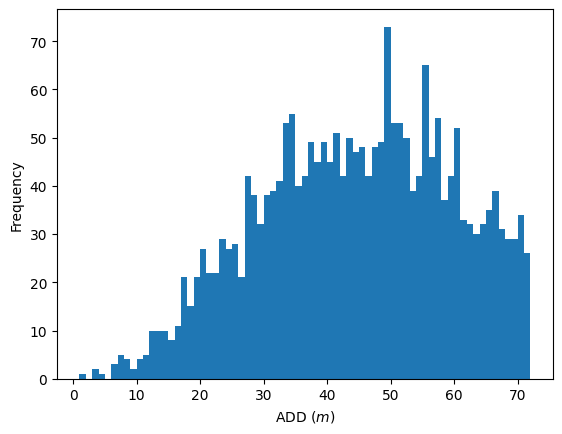

In [8]:
predictions = pd.DataFrame(best_squared_model.predict(X_test), columns=["pos_x", "pos_y", "pos_z", "rot_x", "rot_y", "rot_z"])

add = []

for i in range(len(y_test)):
    add.append(ADD_metric(y_test.loc[i].to_numpy(), predictions.loc[0].to_numpy()))

bin_width = 1
min_bin = int(np.min(add) - (np.min(add) % bin_width))
max_bin = int(np.max(add) + bin_width - (np.max(add) % bin_width))

plt.hist(add, bins=np.arange(min_bin, max_bin + bin_width, bin_width))

#xlim = [0, 1]

plt.xlabel("ADD ($m$)")
plt.ylabel("Frequency")
#plt.xlim(xlim)
plt.show()

---

## Tuning